In [37]:
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 12})

In [39]:
# import internal files
import emulator
import kernels
import data
import historymatch
import plot


In [3]:
def model_eqn_1(x, y):
    return np.cos(np.sqrt(x**2 + 2*y**2))
    #return a + y + x
    
model1 = np.vectorize(model_eqn_1)

In [4]:
def model_eqn_2(x, y):
    #return np.sin(np.sqrt(x**2 + 4*y**2 + 2*a**2))
    return y**2 + x

model2 = np.vectorize(model_eqn_2)

In [58]:
# define parameter space
x_bound = np.array([-2, 2]).reshape(1,-1)
y_bound = np.array([-2, 2]).reshape(1,-1)
input_bounds = np.concatenate((x_bound, y_bound), axis=0)

xvals = np.linspace(input_bounds[0,0], input_bounds[0,1], 1000)
yvals = np.linspace(input_bounds[1,0], input_bounds[1,1], 1000)

In [95]:
# for testing: true datapoints

true_parameters_m1 = [-0.1, 0.3]
true_parameters_m2 = [-0.1, 0.2]

var_exp = 0.1        # observational uncertainty variance
z_1 = model_eqn_1(*true_parameters_m1) + np.random.normal(0, var_exp) # observed datapoint
z_2 = model_eqn_2(*true_parameters_m2) + np.random.normal(0, var_exp) # observed datapoint

In [96]:
# simulation parameters
Ntraining = 50          # number of training points
ndim = 3        # model dimensions
Nsamples = 10000    # number of test points

In [97]:
def plot_1D(variable, model, true_parameters, z, var_exp, ax):
    if variable == 'x':
        true = true_parameters[0]
        true_other = true_parameters[1]
        vals = xvals
        model_args = [vals, true_other]
    elif variable == 'y':
        true = true_parameters[1]
        true_other = true_parameters[0]
        vals = yvals
        model_args = [true_other, vals]
    
    
    func = model(*model_args)
    ax.plot(vals, func)

    ax.axhline(z, color='black', linewidth=1, label='Obs Data')
    ax.axvline(true, color='red', linewidth=1, label='True Param')

    ax.axhline(z+3*np.sqrt(var_exp), color='black', linewidth=1, linestyle='--')
    ax.axhline(z-3*np.sqrt(var_exp), color='black', linewidth=1, linestyle='--', label = r'$\pm 3\sigma_{exp}$')

    idx1 = np.argwhere(np.diff(np.sign( func - z+3*np.sqrt(var_exp)))).flatten()  # upper
    idx2 = np.argwhere(np.diff(np.sign( func - z-3*np.sqrt(var_exp)))).flatten()  # lower

    if len(idx2) == 0:
        ax.axvspan(vals[idx1][0], vals[idx1][1], color='green', alpha=0.2, label='Nonimp region')
    elif len(idx1) == 0:
        ax.axvspan(vals[idx2][0], vals[idx2][1], color='green', alpha=0.2, label='Nonimp region')
    else:
        for i in range(len(idx1)):
            ax.axvspan(vals[idx1][i], vals[idx2][i], color='green', alpha=0.2, label='Nonimp region')
    ax.legend(loc='best')
    ax.set_ylabel(r'$f_1(x, y={})$'.format(true_other))
    ax.set_xlabel('x')

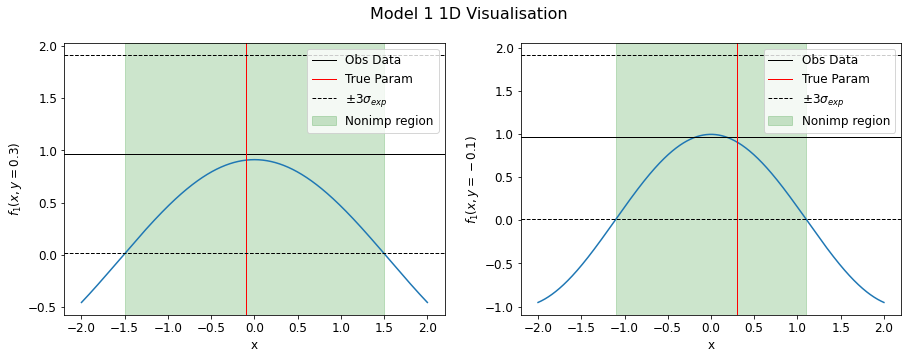

In [98]:
# visualise model 1
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Model 1 1D Visualisation', fontsize=16)

plot_1D('x', model1, true_parameters_m1, z_1, var_exp, ax1)
plot_1D('y', model1, true_parameters_m1, z_1, var_exp, ax2)


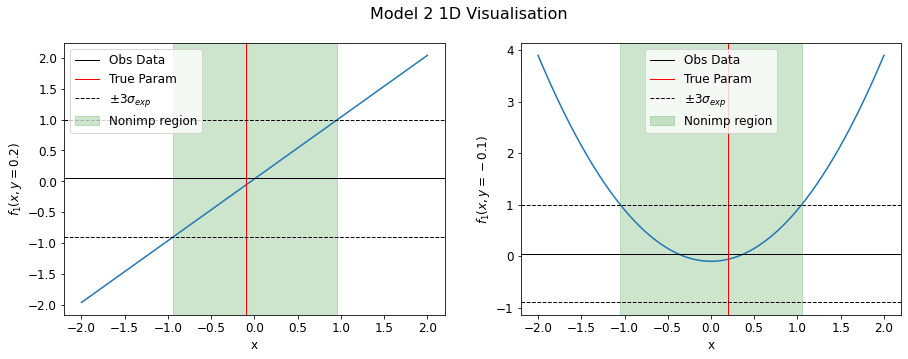

In [99]:
# visualise model 1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Model 2 1D Visualisation', fontsize=16)

plot_1D('x', model2, true_parameters_m2, z_2, var_exp, ax1)
plot_1D('y', model2, true_parameters_m2, z_2, var_exp, ax2)

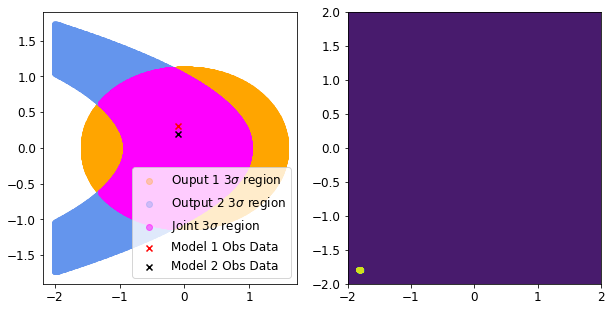

In [100]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

X, Y = np.meshgrid(xvals, yvals)
func_1 = model1(X, Y)
func_2 = model2(X, Y)
xy_grid = np.zeros((len(xvals), len(yvals)))

# plot all parameter values
#ax1.scatter(X,Y, s=5, alpha=0.2)

# find outputs which are within 3sigma of the observed datapoint
idx_1 = np.argwhere(np.logical_and(func_1 > z_1-3*np.sqrt(var_exp), func_1 < z_1+3*np.sqrt(var_exp)))
idx_2 = np.argwhere(np.logical_and(func_2 > z_2-3*np.sqrt(var_exp), func_2 < z_2+3*np.sqrt(var_exp)))

# find joint 3sigma region
idx_joint = np.array([x for x in set(tuple(x) for x in idx_1) & set(tuple(x) for x in idx_2)])

#mean_idx = np.argwhere(np.diff(np.sign( func_grid - z_1)))

#idxtest = np.argwhere(func_grid > z_1-3*np.sqrt(var_exp))

# plot 3sigma range
ax1.scatter(xvals[idx_1[:,1]], yvals[idx_1[:,0]], color='orange', alpha=0.3, label=r'Ouput 1 $3\sigma$ region')
ax1.scatter(xvals[idx_2[:,1]], yvals[idx_2[:,0]], color='cornflowerblue', alpha=0.3, label=r'Output 2 $3\sigma$ region')
ax1.scatter(xvals[idx_joint[:,1]], yvals[idx_joint[:,0]], color='fuchsia', alpha=0.5, label=r'Joint $3\sigma$ region')

#ax1.scatter(xvals[mean_idx[:,1]], yvals[mean_idx[:,0]], color='red', s = 1)

for i in range(len(idx)):
    xy_grid[idx[i,0], idx[i,1]] = 1
    
#for i in range(len(mean_idx)):
    #xy_grid[mean_idx[i,0], mean_idx[i,1]] = 2
    
ax1.scatter(true_parameters_m1[0], true_parameters_m1[1], marker='x', color='red', label='Model 1 Obs Data')
ax1.scatter(true_parameters_m2[0], true_parameters_m2[1], marker='x', color='black', label='Model 2 Obs Data')

ax2.contourf(xvals, yvals, xy_grid, cmap='viridis')
ax1.legend(loc='best')

In [101]:
# create squared-exponential kernel
sigma_cov = 0.2        # sqrt variance of covariance function
beta = 0         # prior expectation

kern = kernels.SE()

In [102]:
def history_match(true_model, parameter_bounds, sigma_cov, var_exp, beta, Ntraining, Nsamples, zlist, ndim, n_outputs, waves=1):
    
    # plot settings
    fig1, axes = plt.subplots(waves, 2, figsize=(12, 6*waves))
    ax_list = fig1.axes

    # find initial parameter volume
    initial_volume = 1
    for i in range(ndim):
        initial_volume = initial_volume * (parameter_bounds[i,1] - parameter_bounds[i,0])
    parameter_bounds_initial = parameter_bounds
    N_regions = 1

    Nsamples_0 = Nsamples
    Ntraining_0 = Ntraining
    for k in range(waves):
        
        ax1 = ax_list[2*k]
        ax2 = ax_list[2*k + 1]

        print('Current wave: ' + str(k+1))

        input_train_list = []
        input_test_list = []
        output_train_list = []

        # iterate over nonimplausible regions
        for n in range(N_regions):
            print('region: ' + str(n))

            # generate initial well spaced inputs for train and test sets
            if k == 0:
                input_train, input_test = data.prepare_data(ndim, Nsamples, Ntraining, parameter_bounds)
                # save this input for optical depth plots - clean later *******
                input_test_0 = input_test
            else:
                input_train = input_train_all[n]
                input_test = input_test_all[n]

            # iterate over model outputs
            implaus_all = np.zeros((len(input_test), n_outputs))

            for output in range(n_outputs):


                if k == 0:
                    # evaluate true model over training inputs
                    output_train = np.zeros(Ntraining)
                    true_model_vec = np.vectorize(true_model[output])
                    output_train = true_model_vec(*input_train.T)
                    # artificially add noise to observations
                    output_train += np.random.normal(0,var_exp)
                    
                else:
                    output_train = output_train_all[n][output]

                # build emulator over nonimplausible region
                GP = emulator.Gaussian_Process(input_train, input_test, output_train, sigma_cov, beta, kern)
                # optimise hyperparameters of emulator
                GP.optimise()
                # fit emulator using training points
                mu, cov, sd = GP.emulate()

                # evaluate implausibility over parameter volume
                for i in range(len(input_test)):
                    implaus_all[i, output] = historymatch.implausibility(mu[i], zlist[output], sd[i], 0, var_exp)
                    
            # choose maximum implausibility
            max_I = np.argmax(implaus_all, axis=1)
            implaus = np.choose(max_I, implaus_all.T)

            # identify implausible region
            input_imp = np.concatenate((input_test, implaus.reshape(-1,1)), axis=1)
            # if region empty, skip
            nonimplausible = np.delete(input_imp, np.where(input_imp[:,-1] > 3), axis=0)
            
            print(nonimplausible)
            
            if nonimplausible.size == 0:
                print('empty')
                continue

            # plot implausibilities and optical depth
            variable_names = ['x', 'y', 'z']
            plot.implausibility_2D(input_imp, parameter_bounds_initial, ax1 , fig1, k, n, [0,1], 
                                   [variable_names[0], variable_names[1]], bins=10)
            ax2.scatter(nonimplausible[:,0], nonimplausible[:,1])
                        
            # isolate implausible regions based on greatest y difference
            implaus_regions = historymatch.find_clusters_3D(nonimplausible, input_test, ndim, parameter_bounds, n_grid=5)
            implaus_volumes = []
            implaus_N_pts = []
            # identify nonimplausible region boundaries and plot
            for i in range(len(implaus_regions)):

                group_i = implaus_regions[i]

                # plot first wave regions to visually check results
                #if k == 0:
                    
                    #ax2.set_title('Wave 1 Nonimplausible Regions')
                    #ax2.scatter(implaus_regions[i][:,0], implaus_regions[i][:,1], implaus_regions[i][:,2])
                    #ax2.set_xlabel('x')
                    #ax2.set_ylabel('y')
                    #ax2.set_zlabel('z')
                    #ax2.set_xlim([parameter_bounds_initial[0,0],parameter_bounds_initial[0,1]])
                    #ax2.set_ylim([parameter_bounds_initial[1,0],parameter_bounds_initial[1,1]])
                

                # find nonimplausible boundaries
                parameter_bounds = np.empty((0,2))
                volume = 1
                if group_i.shape[0] == 1:
                    for j in range(ndim):
                        min_i = group_i[:,j].min() - 0.01
                        max_i = group_i[:,j].max() + 0.01
                        parameter_bounds = np.concatenate((parameter_bounds, np.array([min_i, max_i]).reshape(1,-1)), axis=0)
                        volume = volume * (max_i - min_i)

                else:
                    for j in range(ndim):
                        min_i = group_i[:,j].min()
                        max_i = group_i[:,j].max()
                        parameter_bounds = np.concatenate((parameter_bounds, np.array([min_i, max_i]).reshape(1,-1)), axis=0)
                        volume = volume * (max_i - min_i)

                # rescale number of points to sample in parameter space
                implaus_volumes.append(volume)
                
            total_volume = sum(implaus_volumes)

            for i in range(len(implaus_regions)):
                
                print(implaus_regions[i].shape)

                Ntraining = int(np.ceil((implaus_volumes[i]/total_volume)*Ntraining))
                Nsamples = int(np.ceil((implaus_volumes[i]/total_volume)*Nsamples))
                

                # redefine nonimplausible space & generate new training points
                input_train_i, input_test_i = data.prepare_data(ndim, Nsamples, Ntraining, parameter_bounds)

                # evaluate true model over training inputs
                output_train_region = []
                for output in range(n_outputs):
                    output_train_i = np.zeros(len(input_train_i))
                    true_model_vec = np.vectorize(true_model[output])
                    output_train_i = true_model_vec(*input_train_i.T)
                    # artificially add noise to observations
                    output_train_i += np.random.normal(0,var_exp)
                    output_train_region.append(np.array(output_train_i))

                input_train_list.append(input_train_i)
                input_test_list.append(input_test_i)
                output_train_list.append(output_train_region)
        
        input_train_all = input_train_list

        input_test_all = input_test_list
        output_train_all = output_train_list

        N_regions = len(input_train_all)
        
        ax2.scatter(xvals[idx_joint[:,1]], yvals[idx_joint[:,0]], color='fuchsia', alpha=0.5, label=r'Joint $3\sigma$ region')
        ax2.set_xlim([parameter_bounds_initial[0,0], parameter_bounds_initial[0,1]])
        ax2.set_ylim([parameter_bounds_initial[1,0], parameter_bounds_initial[1,1]])


Current wave: 1
region: 0
[3.]
[3.]
[[-7.25006331e-02  1.76818895e-01  6.74029827e-01]
 [ 2.42233678e-01  8.24152112e-02  2.83162466e+00]
 [ 1.90524757e-01  1.72874425e-03  2.34313912e+00]
 ...
 [ 1.86323891e-01 -1.19989537e-01  2.40328382e+00]
 [-4.55374188e-02 -2.42701771e-02  9.78319250e-01]
 [-5.46684000e-01  4.72846848e-01  2.73483665e+00]]
(442, 2)
Current wave: 2
region: 0
[3.]
[3.]
[[-0.20508627  0.40773159  2.55811664]
 [ 0.24929775 -0.54305276  2.41630466]
 [-0.42279822  0.62612137  1.34358493]
 [ 0.1485319   0.63664469  2.20065611]
 [ 0.11470171  0.37545238  0.51852149]
 [-0.31415666  0.30447037  0.41976935]
 [-0.19965786  0.55339887  2.48808445]
 [-0.198825   -0.34481078  2.08578541]
 [-0.55382856  0.62919088  0.47694131]
 [-0.02087694  0.39936748  2.27416726]
 [-0.28182135  0.06163659  2.14146558]
 [-0.18251811  0.50547265  2.97301836]
 [-0.36634745 -0.16156469  1.72249165]
 [ 0.09147064  0.59541607  1.56240305]
 [ 0.22443684  0.20762705  2.01198932]
 [-0.29404464  0.12154

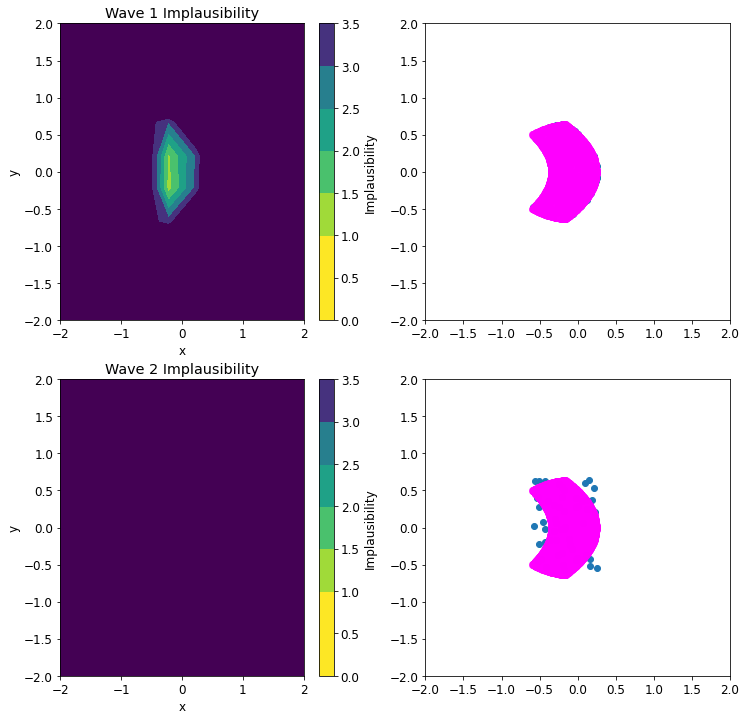

In [86]:
history_match([model_eqn_1, model_eqn_2], input_bounds, sigma_cov, var_exp, beta, 
              Ntraining, Nsamples, zlist=[z_1, z_2], ndim=2, n_outputs=2, waves=2)